In [45]:
'''
get_one_set_one_Xscore(set, model, scaler) -> list of scores 

get_one_set_one_Pscore(set, model, scaler) -> list of scores

get_one_set_all_scores(set) -> 2d list of scores (models labeled) and totals

get_all_sets_all_scores -> above method but for all sets 

'''

'\nget_one_set_one_Xscore(set, model, scaler) -> list of scores \n\nget_one_set_one_Pscore(set, model, scaler) -> list of scores\n\nget_one_set_all_scores(set) -> 2d list of scores (models labeled) and totals\n\nget_all_sets_all_scores -> above method but for all sets \n\n'

In [46]:
import glob
import numpy as np
import pandas as pd 
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import colorsys
import joblib

In [47]:
import torch
import torch.nn as nn

class DeeperNLCModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        dropout_rate = 0.5

        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Linear(8, 4),
            nn.BatchNorm1d(4),
            nn.ReLU(),

            nn.Linear(4, 1)  # Final output layer
        )

    def forward(self, x):
        return self.model(x)


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, input, target):
        bce_loss = self.bce(input, target)
        pt = torch.exp(-bce_loss)
        focal = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal.mean()


In [48]:
def input_from_csv(set_path):
    X = pd.read_csv(set_path)
    ids = X['id']
    X = X.drop(columns=['id', 'is_centrosymmetric', "crystal_system"])
    X = X.values
    return X, ids

In [49]:
def scale(scaler_path, X):
    scaler = joblib.load(scaler_path)
    X = scaler.transform(X)
    return X

In [50]:
def score_with_xgb(model_path, X):
    model = xgb.XGBClassifier()
    model.load_model(model_path)
    probs = model.predict_proba(X)[:, 1]
    score = np.zeros_like(probs, dtype=int)

    thresholds = np.round(np.arange(0.30, 1.00, 0.01), 2)
    
    for threshold in thresholds:
        score += (probs >= threshold).astype(int)
    print(f"{model_path}: Done scoring")

    return score 


In [51]:
def score_with_torch(model_path, X):
    input_tensor = torch.tensor(X, dtype=torch.float32)
    #model = torch.load(model_path, weights_only=False)
    model = DeeperNLCModel(296)  # replace with actual feature count
    # Load the state dict
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    model.eval()

    # Run inference
    with torch.no_grad():
        outputs = model(input_tensor)

    # If output is logits, convert to probabilities
    if outputs.shape[1] == 1:
        probs = torch.sigmoid(outputs).squeeze().numpy()  # shape: (n_samples,)
    else:
        probs = torch.softmax(outputs, dim=1)[:, 1].numpy()  # shape: (n_samples,)

    thresholds = np.round(np.arange(0.30, 1.00, 0.01), 2)

    # Apply thresholds to compute scores
    score = np.zeros_like(probs, dtype=int)
    for threshold in thresholds:
        score += (probs >= threshold).astype(int)

    print(f"{model_path}: Done scoring")
    return(score)

In [52]:
def get_xgb_ensemble(set_path):
    X, ids = input_from_csv(set_path)
    model_paths = glob.glob("models/x*")
    scaler_paths = glob.glob("scalers/x*")
    print(len(model_paths), len(scaler_paths))
    model_scores = []

    for i in range(len(model_paths)):
        X = scale(scaler_paths[i], X)
        score = score_with_xgb(model_paths[i], X)
        print(np.argmax(score))
        model_scores.append(score)

    scores_df = pd.DataFrame(model_scores).T
    scores_df.columns = [f"model_{i}_score" for i in range(len(model_scores))]
    scores_df["total_score"] = scores_df.sum(axis=1)
    scores_df.insert(0, "id", ids.values)

    # Save
    scores_df.to_csv("xgb_scores.csv", index=False)
    print("Saved threshold_scores.csv with per-model and total scores.")

In [53]:
def get_torch_ensemble(set_path):
    X, ids = input_from_csv(set_path)
    model_paths = glob.glob("models/t*")
    scaler_paths = glob.glob("scalers/t*")
    print(len(model_paths), len(scaler_paths))
    model_scores = []

    for i in range(len(model_paths)):
        X = scale(scaler_paths[i], X)
        score = score_with_torch(model_paths[i], X)
        print(model_paths[i], scaler_paths[i])
        model_scores.append(score)

    scores_df = pd.DataFrame(model_scores).T
    scores_df.columns = [f"model_{i}_score" for i in range(len(model_scores))]
    scores_df["total_score"] = scores_df.sum(axis=1)
    scores_df.insert(0, "id", ids.values)

    # Save
    scores_df.to_csv("torch_scores.csv", index=False)
    print("Saved threshold_scores.csv with per-model and total scores.")

In [54]:
#path = 'data/Set_15/featurized_materials.csv'
path = 'data/combined.csv'
get_xgb_ensemble(path)
get_torch_ensemble(path)

10 10
models\x0.json: Done scoring
74662
models\x1.json: Done scoring
6285
models\x2.json: Done scoring
3528
models\x3.json: Done scoring
4313
models\x4.json: Done scoring
11023
models\x5.json: Done scoring
111923
models\x6.json: Done scoring
5452
models\x7.json: Done scoring
6416
models\x8.json: Done scoring
73
models\x9.json: Done scoring
0
Saved threshold_scores.csv with per-model and total scores.
10 10
models\t0.pt: Done scoring
models\t0.pt scalers\t0.pkl
models\t1.pt: Done scoring
models\t1.pt scalers\t1.pkl
models\t2.pt: Done scoring
models\t2.pt scalers\t2.pkl
models\t3.pt: Done scoring
models\t3.pt scalers\t3.pkl
models\t4.pt: Done scoring
models\t4.pt scalers\t4.pkl
models\t5.pt: Done scoring
models\t5.pt scalers\t5.pkl
models\t6.pt: Done scoring
models\t6.pt scalers\t6.pkl
models\t7.pt: Done scoring
models\t7.pt scalers\t7.pkl
models\t8.pt: Done scoring
models\t8.pt scalers\t8.pkl
models\t9.pt: Done scoring
models\t9.pt scalers\t9.pkl
Saved threshold_scores.csv with per-mod

In [55]:
xgb_scores_df = pd.read_csv("xgb_scores.csv")

# Sort by total_score in descending order and take top 10
top10_xgb = xgb_scores_df.sort_values(by="total_score", ascending=False).head(20)

# Print only ID and total score
print("Top 10 Highest Scoring Materials (XGBoost):")
print(top10_xgb[["id", "total_score"]])

Top 10 Highest Scoring Materials (XGBoost):
                id  total_score
82502    mp-754712          209
70678   mp-1214186          209
85574   mp-1192919          209
78662    mp-542769          208
7277    mp-1180282          208
12748   mp-1224461          207
75111   mp-1182309          207
69953   mp-1188937          207
79087    mp-755829          207
82963    mp-726207          207
4117       mp-1771          206
28165    mp-722003          206
75148   mp-1189643          205
20479    mp-722050          205
7292    mp-1212209          205
43312   mp-1391114          205
93130   mp-1104744          205
7317     mp-616407          205
89579   mp-1105968          204
114834   mp-554491          203


In [56]:
torch_scores_df = pd.read_csv("torch_scores.csv")

# Sort by total_score descending and select top 10
top10 = torch_scores_df.sort_values(by="total_score", ascending=False).head(20)

# Print the results
print("Top 10 Highest Scoring Materials:")
print(top10[["id", "total_score"]])

Top 10 Highest Scoring Materials:
                id  total_score
9745     mp-643934          176
40932   mp-1212700          176
54478    mp-659211          176
88014    mp-850788          176
86754     mp-27445          176
86498   mp-1411223          176
58860   mp-1100951          176
93989    mp-850332          175
5051     mp-860537          175
58708    mp-582549          175
87689    mp-761200          175
63230    mp-755181          175
61373   mp-2214898          174
20454    mp-707535          174
94045   mp-1213037          174
63375    mp-758857          174
59163   mp-1219432          174
109010  mp-1222158          174
58884   mp-1101221          174
63166    mp-753334          174


In [57]:
# Read the CSV files
torch_df = pd.read_csv("torch_scores.csv")
xgb_df = pd.read_csv("xgb_scores.csv")

# Extract id and last column (total score) from each
torch_scores = torch_df.iloc[:, [0, -1]].copy()
xgb_scores = xgb_df.iloc[:, [0, -1]].copy()

# Rename columns
torch_scores.columns = ['id', 'torch_score']
xgb_scores.columns = ['id', 'xgb_score']

# Merge on id
combined_df = pd.merge(torch_scores, xgb_scores, on='id', how='inner')

# Create total_score column as sum of torch and xgb scores
combined_df['total_score'] = combined_df['torch_score'] + combined_df['xgb_score']

# Save to CSV
combined_df.to_csv("combined_scores.csv", index=False)

In [ ]:
top_ten = combined_df.sort_values(by='total_score', ascending=False).head(20)

print(top_ten)

                id  torch_score  xgb_score  total_score
57985   mp-1067644          172        194          366
55643       mp-690          162        202          364
87248    mp-666728          164        198          362
89598   mp-1105968          157        204          361
1440       mp-7260          163        198          361
108403   mp-625385          162        196          358
89393    mp-625104          163        193          356
4021    mp-1180500          163        188          351
69976   mp-1189432          173        178          351
9757     mp-643934          176        175          351


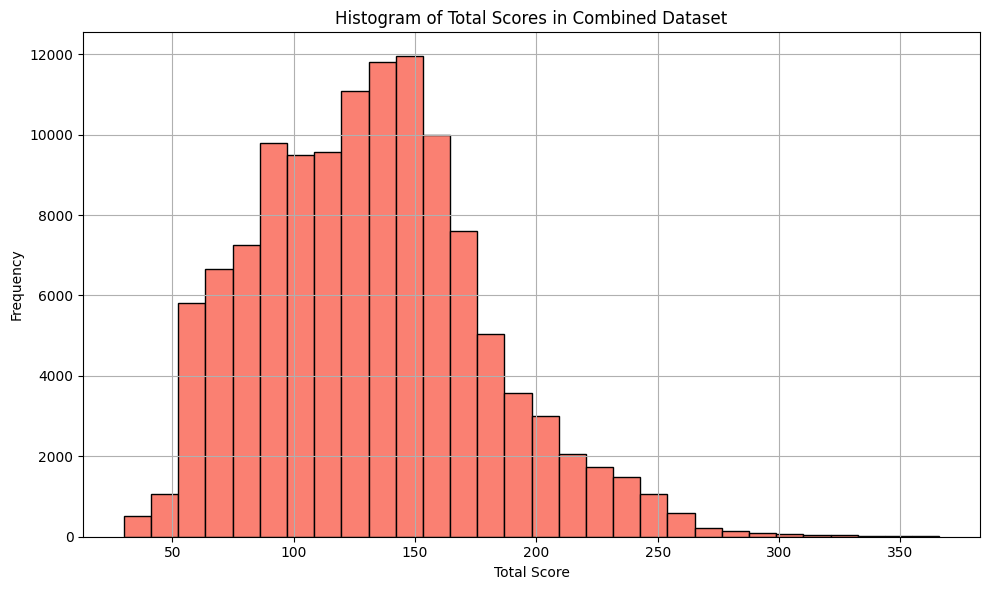

In [59]:
# Plot histogram of total_score
plt.figure(figsize=(10, 6))
plt.hist(combined_df['total_score'], bins=30, edgecolor='black', color='salmon')
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.title("Histogram of Total Scores in Combined Dataset")
plt.grid(True)
plt.tight_layout()
plt.show()

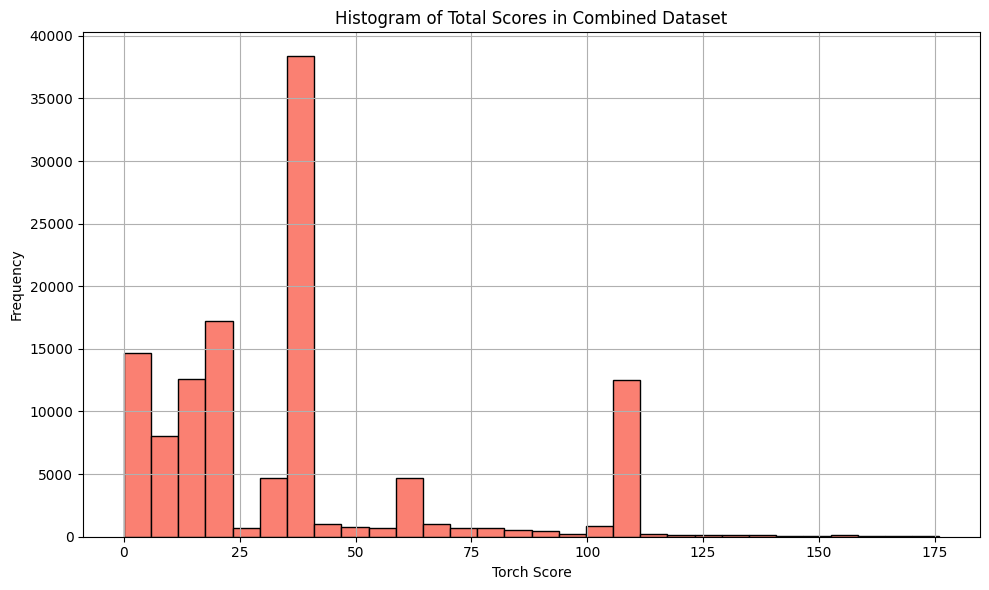

In [60]:
# Plot histogram of total_score
plt.figure(figsize=(10, 6))
plt.hist(torch_scores_df['total_score'], bins=30, edgecolor='black', color='salmon')
plt.xlabel("Torch Score")
plt.ylabel("Frequency")
plt.title("Histogram of Total Scores in Combined Dataset")
plt.grid(True)
plt.tight_layout()
plt.show()

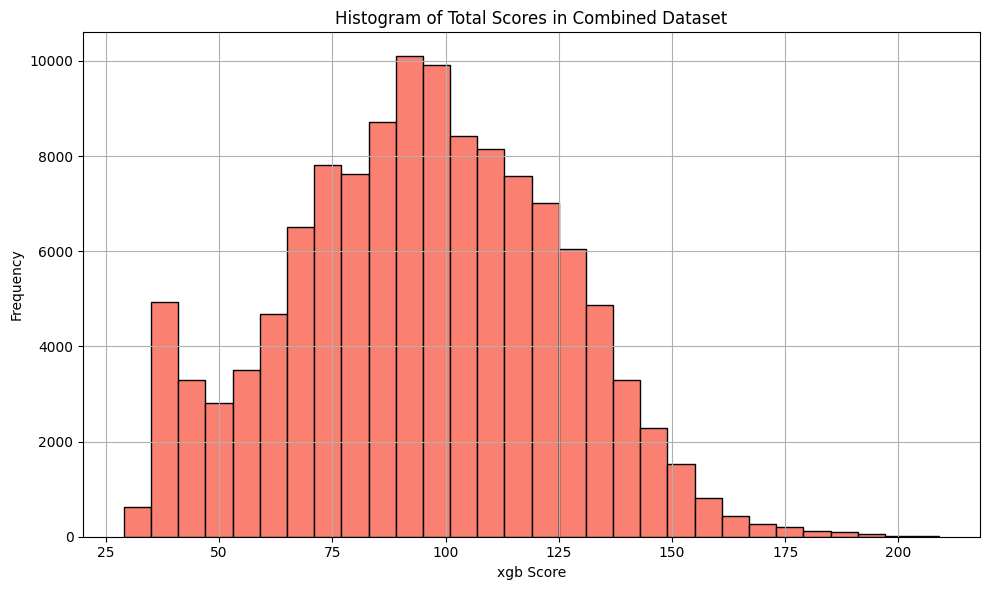

In [61]:
# Plot histogram of total_score
plt.figure(figsize=(10, 6))
plt.hist(xgb_scores_df['total_score'], bins=30, edgecolor='black', color='salmon')
plt.xlabel("xgb Score")
plt.ylabel("Frequency")
plt.title("Histogram of Total Scores in Combined Dataset")
plt.grid(True)
plt.tight_layout()
plt.show()